In [90]:
import pandas as pd
import os 
import subprocess
import warnings 
from src.files import XMLFile, FASTAFile, GBFFFile, InterProScanFile
from src import get_genome_id
from src import fillna
from src.dataset import Dataset
from utils import * 
import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
import dataframe_image as dfi
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
import pingouin
import subprocess

%load_ext autoreload 
%autoreload 2

confusion_matrix_map = {'tp':'true positive', 'fp':'false positive', 'tn':'true negative', 'fn':'false negative'}
dtypes = {'top_hit_partial':str, 'query_partial':str, 'top_hit_translation_table':str, 'top_hit_codon_start':str}

# TODO: Definitely want to look at model confidence on the sequences. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
model_name = 'campylobacterota_esm_650m_gap_v1'

predictions['all']
pred_df = load_predict('../data/predict/campylobacterota_dataset_predict.csv', model_name=model_name)
pred_df = pred_df.merge(pd.read_csv('../data/campylobacterota_dataset.csv', dtype=dtypes, index_col=0), left_index=True, right_index=True, how='left')

genome_metadata_df = pd.read_csv('../data/genome_metadata.csv', index_col=0)
genome_metadata_df = genome_metadata_df[genome_metadata_df.phylum == 'Campylobacterota']

In [151]:
def table_1(pred_df:pd.DataFrame):
    pred_df = load_predict('../data/predict/campylobacterota_dataset_predict.csv', model_name=None)
    print(pred_df.columns)
    pred_df = pred_df.merge(pd.read_csv('../data/campylobacterota_dataset.csv', dtype=dtypes, index_col=0), left_index=True, right_index=True, how='left')

    table_df = []
    for model_name in ['campylobacterota_esm_650m_gap_v1', 'campylobacterota_esm_650m_gap_v2', 'campylobacterota_esm_650m_gap_v3']:
        df = pred_df.groupby('category')[f'{model_name}_label'].value_counts().reset_index()
        df = df.pivot(columns=f'{model_name}_label', values='count', index='category')
        df.columns = pd.MultiIndex.from_tuples([(model_name, 'spurious'), (model_name, 'real')])
        # df = df.rename(columns={0:'spurious', 1:'real'})
        table_df.append(df)
    pd.concat(table_df, axis=1)
    return table_df 

table_df = table_1(pred_df) 
table_df.columns.name

Index(['campylobacterota_esm_650m_gap_v3_label',
       'campylobacterota_esm_650m_gap_v3_output_0',
       'campylobacterota_esm_650m_gap_v3_output_1', 'genome_id', 'seq',
       'model_label', 'model_output_0', 'model_output_1'],
      dtype='object')


KeyError: 'Column not found: campylobacterota_esm_650m_gap_v1_label'

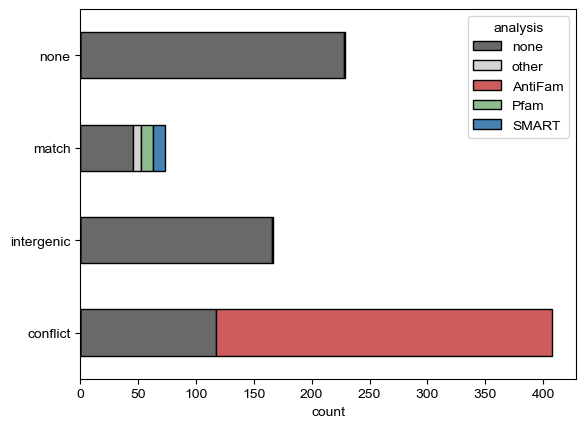

In [134]:
def figure_1(pred_df:pd.DataFrame):
    if not os.path.exists(f'../data/{model_name}_spurious_interpro.tsv'):
        FASTAFile(df=pred_df[pred_df.model_label == 0]).write(f'../data/{model_name}_spurious.faa')
        cmd = f'~/interproscan/interproscan-5.73-104.0/interproscan.sh -i ../data/{model_name}_spurious.faa -o ../data/{model_name}_spurious_interpro.tsv -f tsv'
        subprocess.run(cmd, shell=True, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    interpro_df = InterProScanFile(f'../data/{model_name}_spurious_interpro.tsv').to_df(drop_duplicates=True, max_e_value=1e-5).drop(columns=['length', 'stop', 'start'])

    fig = plt.figure()
    ax = fig.add_subplot()

    ax_df = pred_df[['model_label', 'category', 'label']].copy()
    ax_df = fillna(ax_df.merge(interpro_df, left_index=True, right_index=True, how='left'), rules={str:'none'}, errors='ignore')
    ax_df = ax_df[ax_df.model_label == 0]
    ax_df['analysis'] = ax_df.analysis.replace({'Gene3D':'other', 'SUPERFAMILY':'other', 'PANTHER':'other'})
    ax_df = ax_df.groupby('category').analysis.value_counts().reset_index()
    ax_df = ax_df.pivot(index='category', columns='analysis', values='count').fillna(0)
    ax_df = ax_df.loc[:, ['none', 'other', 'AntiFam', 'Pfam', 'SMART']]
    # print(ax_df.columns)
    colors = {'none':'dimgray', 'Pfam':'darkseagreen', 'AntiFam':'indianred', 'MobiDBLite':'steelblue', 'SMART':'steelblue', 'other':'lightgray'}
    ax_df.plot(kind='barh', stacked=True, ax=ax, edgecolor='black', color=colors) # color=['indianred', 'darkseagreen', 'lightsteelblue', 'steelblue', 'dimgray', 'lightgray'])
    ax.set_ylabel('')
    ax.set_xlabel('count')
    plt.show()

figure_1(pred_df)

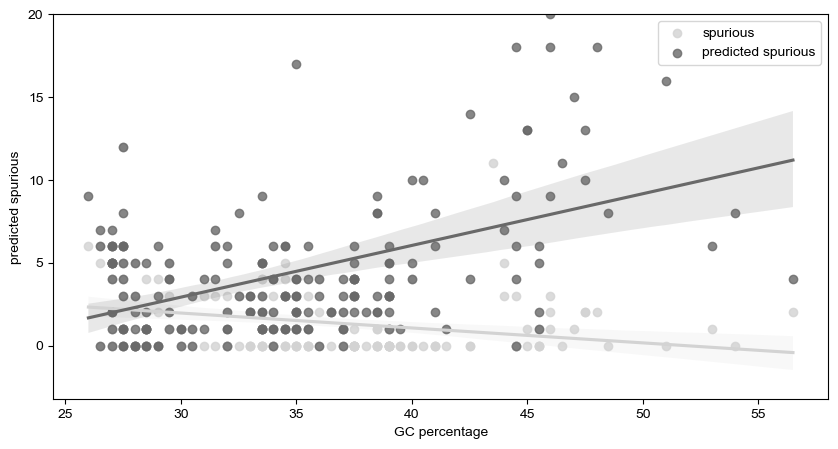

In [ ]:
# https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-11-119
def figure_1(pred_df:pd.DataFrame, genome_metadata_df:pd.DataFrame):

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot()

    ax_df = pred_df[['in_train_dataset', 'genome_id']].groupby('genome_id').first()
    ax_df['spurious'] = pred_df.groupby('genome_id').apply(lambda df : (df.label == 'spurious').sum(), include_groups=False)
    ax_df['predicted spurious'] = pred_df.groupby('genome_id').apply(lambda df : (df.model_label == 0).sum(), include_groups=False)
    ax_df['difference'] = ax_df['predicted spurious'] - ax_df['spurious']
    ax_df = ax_df.merge(genome_metadata_df[['gc_percent', 'n_gene_protein_coding']], right_index=True, left_index=True, how='left')
    # ax_df = ax_df.rename(columns={'gc_percent':'GC percentage'})
    ax_df = ax_df.reset_index()

    # sns.scatterplot(data=ax_df, x='genome_id', y='spurious', ax=ax, palette=['lightsteelblue', 'lightsteel'], hue='in_train_dataset')
    # sns.scatterplot(data=ax_df, x='genome_id', y='spurious', ax=ax, palette=['lightsteelblue', 'lightsteel'], hue='in_train_dataset')
    ax = sns.regplot(data=ax_df, x='gc_percent', y='spurious', color='lightgray', ax=ax, label='spurious')
    ax = sns.regplot(data=ax_df, x='gc_percent', y='predicted spurious', color='dimgray', ax=ax, label='predicted spurious')
    ax.set_xlabel('GC percentage')
    # ax.legend(handles=ax.getlines(), labels=['spurious', 'predicted spurious'])
    ax.legend()
    ax.set_ylim(ymax=20)

    plt.show()

figure_1(pred_df, genome_metadata_df)



In [36]:
is_spurious = lambda df : df.label == 'spurious'

is_intergenic = lambda df : ~is_spurious(df) & (df.category == 'intergenic')
is_match = lambda df : ~is_spurious(df) & (df.category == 'match')
is_conflict = lambda df : ~is_spurious(df) & (df.category == 'conflict')
is_none = lambda df : ~is_spurious(df) & (df.category == 'none') # These are the suspect sequences. 

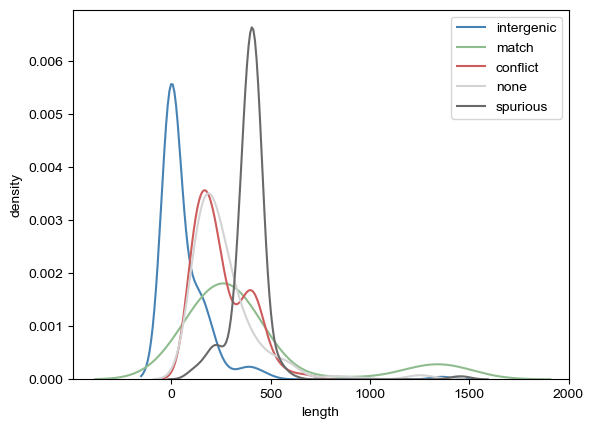

In [136]:
def figure_1(pred_df:pd.DataFrame, max_length:int=1000):
    pred_df = pred_df[pred_df.model_label == 0].copy()

    fig = plt.figure()
    ax = fig.add_subplot()

    colors = ['steelblue', 'darkseagreen', 'indianred', 'lightgray', 'dimgray']
    categories = ['intergenic', 'match', 'conflict', 'none', 'spurious']
    masks = [is_intergenic(pred_df), is_match(pred_df), is_conflict(pred_df), is_none(pred_df), is_spurious(pred_df)]
    ax_df = pred_df.copy()
    ax_df['category'] = np.select(masks, categories, default='none')
    ax_df = ax_df[['category', 'query_length']]
    ax_df = ax_df.rename(columns={'query_length':'length'})

    for category, color in zip(categories, colors):
        sns.kdeplot(data=ax_df[ax_df.category == category], x='length', ax=ax, linewidth=1.5, color=color, label=category, common_norm=False)
    ax.legend()
    ax.set_xlim(xmax=2000)
    ax.set_ylabel('density')
    plt.show()

figure_1(pred_df)

In [20]:
(pred_df.model_label == 0).sum()

np.int64(877)

In [137]:
# genome_metadata_df = load_genome_metadata()
pred_df = load_predict('../data/predict/campylobacterota_dataset_test_predict.csv', model_name='campylobacterota_esm_650m_gap_v1')
# pred_df['model_confusion_matrix'] = pred_df.model_confusion_matrix.replace(confusion_matrix_map)
pred_df = pred_df.merge(pd.read_csv('../data/campylobacterota_dataset_test.csv', dtype=dtypes, index_col=0, low_memory=False).drop(columns=['label']), left_index=True, right_index=True, how='left')

In [138]:
def table_1(path:str=None):

    # model_names = [model_name.replace('.pkl', '') for model_name in os.listdir('../models/')]
    # model_names = ['campylobacterota_esm_650m_gap_v2', 'campylobacterota_esm_650m_gap_v1']
    model_names = ['campylobacterota_esm_650m_gap_v1']
    table_df = list()

    for model_name in model_names:
        pred_df = load_predict('../data/predict/campylobacterota_dataset_test_predict.csv', model_name=model_name)
        row = dict()
        row['feature type'] = re.search('(esm_650m_gap|pt5_3b_gap|esm_3b_gap)', model_name).group(1) 
        row['model_name'] = model_name
        row.update(pred_df.model_confusion_matrix.replace(confusion_matrix_map).value_counts().to_dict())
        row['accuracy'] = np.round(balanced_accuracy_score(pred_df.label, pred_df.model_label), 4)
        table_df.append(row)
    return pd.DataFrame(table_df).set_index('model_name')

table_1().sort_values('false positive')


,feature type,true positive,true negative,false negative,false positive,accuracy
model_name,,,,,,
campylobacterota_esm_650m_gap_v1,esm_650m_gap,12550,56,6,1,0.991


In [143]:
warnings.simplefilter('ignore')

def table_2(pred_df:pd.DataFrame, path:str='../figures/filter-table_1.png'):
    pred_df = pred_df.copy()
    pred_df['model_confusion_matrix'] = pred_df.model_confusion_matrix.replace(confusion_matrix_map)
    
    table_df = dict()
    table_df['accuracy'] = pred_df.groupby('genome_id').apply(lambda df : balanced_accuracy_score(df.label, df.model_label) , include_groups=False)
    
    for confusion_matrix, df in pred_df.groupby('model_confusion_matrix'):
        table_df[confusion_matrix] = df.groupby('genome_id').apply(len, include_groups=False)
    table_df = pd.DataFrame(table_df).fillna(0)
    table_df = table_df.sort_values('false negative', ascending=False)
    dfi.export(table_df.iloc[:50], path)
    return table_df


table_2(pred_df)

108335 bytes written to file /tmp/tmpvy21r97t/temp.png


,accuracy,false negative,false positive,true negative,true positive
genome_id,,,,,
GCF_000265295.1,0.992218,2.0,0.0,0.0,255
GCF_000259275.1,0.996914,1.0,0.0,0.0,323
GCF_000420385.1,0.999029,1.0,0.0,1.0,514
GCF_005083985.2,0.997680,1.0,0.0,0.0,430
GCF_021300655.1,0.994975,1.0,0.0,0.0,198
GCF_000597725.1,1.000000,0.0,0.0,0.0,628
GCF_000364285.1,0.500000,0.0,1.0,0.0,614
GCF_000162575.1,1.000000,0.0,0.0,0.0,129
GCF_001693335.1,1.000000,0.0,0.0,0.0,274


In [ ]:
pred_df[pred_df.model_confusion_matrix == 'false positive'].ref_product.value_counts()
pred_df[pred_df.model_confusion_matrix == 'true negative'].ref_product.value_counts()

pred_fp_df = pred_df[pred_df.model_confusion_matrix == 'false positive']
pred_tn_df = pred_df[pred_df.model_confusion_matrix == 'true negative']

pred_df[(pred_df.ref_product == 'hypothetical protein') & pred_df.ref_seq.isnull()][['ref_pseudo', 'ref_product', 'partial', 'ref_evidence_type', 'ref_partial']]
pred_fp_df[(pred_fp_df.ref_product == 'hypothetical protein')].value_counts('ref_evidence_type')
pred_tn_df[(pred_tn_df.ref_product == 'hypothetical protein')].value_counts('ref_evidence_type')

ref_evidence_type
ab initio prediction      6368
similar to AA sequence    3647
protein motif              202
profile                     14
Name: count, dtype: int64

In [ ]:
train_df = pd.read_csv('../data/filter_dataset_train.csv', index_col=0)
test_df = pd.read_csv('../data/filter_dataset_test.csv', index_col=0)

x_train, y_train = train_df.seq.apply(len).values, train_df.label.values
x_test, y_test = test_df.seq.apply(len).values, test_df.label.values

model = LogisticRegression(class_weight='balanced', C=0.001, tol=1e-8)
model.fit(x_train.reshape(-1, 1), y_train)

y_test_pred = model.predict(x_test.reshape(-1, 1))
y_train_pred = model.predict(x_train.reshape(-1, 1))

print('Balanced test accuracy:', balanced_accuracy_score(y_test, y_test_pred.ravel()))
print('Balanced train accuracy:', balanced_accuracy_score(y_train, y_train_pred.ravel()))

Balanced test accuracy: 0.7081700317418668
Balanced train accuracy: 0.70982568099759


In [ ]:
# train_metadata_df = pd.read_csv('../data/filter_dataset_train.csv', index_col=0, low_memory=False)
# test_metadata_df = pd.read_csv('../data/filter_dataset_test.csv', index_col=0, low_memory=False)

np.intersect1d(test_metadata_df.index, train_metadata_df.index)

array(['NC_000962.3_1', 'NC_000962.3_10', 'NC_000962.3_100', ...,
       'NZ_WNKU01000117.1_2', 'NZ_WNKU01000123.1_1',
       'NZ_WNKU01000130.1_1'], shape=(331385,), dtype=object)

In [ ]:
len(train_metadata_df)

331385

In [ ]:
len(pd.read_hdf('../data/filter_dataset_test.h5', key='metadata'))